### Cluster state knitting
Let's build some cluster states out of elementary gates.

In [2]:
%matplotlib inline
import numpy as np
import qutip as qt
import matplotlib
import matplotlib.pyplot as plt
from functools import reduce
import networkx as nx


def show_graph(V, E):
    G = nx.Graph()
    G.graph['dpi'] = 40
    G.add_nodes_from(V)
    G.add_edges_from(E)
    return nx.draw(G, nx.spring_layout(G), labels={i: str(i) for i in V})

In [3]:
from qutip.qip.gates import swap

X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()
CZ = qt.qip.gates.controlled_gate(Z)
def cz(i=0, j=1, N=4):
    return qt.qip.gates.controlled_gate(
        Z, N=N, control=i, target=j
    )

CNOT = qt.qip.gates.cnot()
Id = X**2
SZ = CZ * swap()
def sz(i=0, j=1, N=4):
    return cz(i=i, j=j, N=N) * swap(
        N=N, targets=[i, j])

ket_0 = qt.Qobj(np.array([1, 0]).reshape((2, 1)))
ket_plus = qt.hadamard_transform() * ket_0

def graph_state_unitary(n, E):
    # n = |V|
    # E = [(i, j), ...]
    return reduce(
        lambda a, b: a*b,
        (qt.qip.gates.controlled_gate(
            Z, N=n,
            control=i, target=j
        )
        for i, j in E)
    )

### 1D cluster state generation

False
True


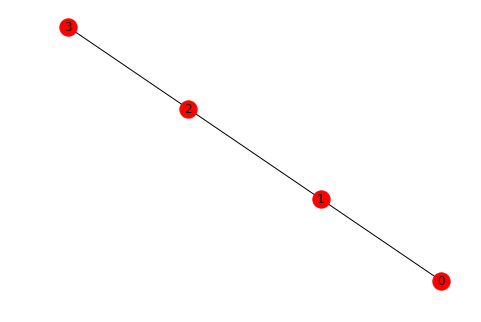

In [4]:
# desired graph edges
E = [(0, 1), (1, 2), (2, 3)]
show_graph(range(4), E)

# initial state
Psi = qt.tensor(4*[ket_plus])

# cluster-state generation procedure
procedure_1D = sz(0, 1) * sz(0, 2) * sz(0, 3)

print(procedure_1D == graph_state_unitary(4, E))
print(procedure_1D * Psi == graph_state_unitary(4, E) * Psi)

^^ 
the procedure yields the desired state, but does not apply the same unitary operation

### 2D cluster state generation

False
True


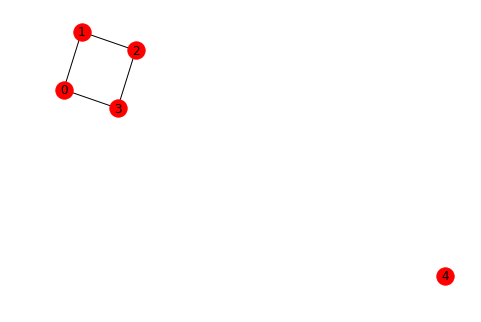

In [5]:
# use 5 qubits this time
# we will use qubit index 4 as flying qubit
N = 5

# desired graph edges (square)
E = [(0, 1), (1, 2), (2, 3), (3, 0)]
show_graph(range(N), E)

# initial state
Psi = qt.tensor(N*[ket_plus])

# cluster-state generation procedure
procedure_2D = swap(targets=[4, 3], N=N) * cz(i=4, j=0, N=N) * cz(i=4, j=2, N=N) * \
    swap(targets=[4, 1], N=N) * cz(i=4, j=0, N=N) * cz(i=4, j=2, N=N)

print(procedure_2D == graph_state_unitary(5, E))
print(procedure_2D * Psi == graph_state_unitary(5, E) * Psi)

### 3D cluster state generation

False
False


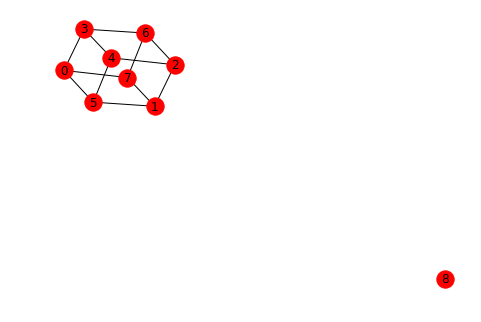

In [6]:
N = 9

f = 8

# desired graph edges (cube)
E = [(0, 3),
 (0, 5),
 (0, 7),
 (1, 2),
 (1, 5),
 (1, 7),
 (2, 4),
 (2, 6),
 (3, 4),
 (3, 6),
 (4, 5),
 (6, 7)]

show_graph(range(N), E)

# initial state
Psi = qt.tensor(N*[ket_plus])

# cluster-state generation procedure
# 1, 2, 6, 7
lower_square = swap(targets=[f, 6], N=N) * cz(i=f, j=7, N=N) * cz(i=f, j=2, N=N) * \
    swap(targets=[f, 1], N=N) * cz(i=f, j=7, N=N) * cz(i=f, j=2, N=N)
# 3 - (6, 4, 0)
upper_corner_1 = swap(targets=[f, 3], N=N) * cz(i=f, j=6, N=N) * cz(i=f, j=4, N=N) * \
    cz(i=f, j=0, N=N)

# 5 - (1, 4, 0)
upper_corner_2 = swap(targets=[f, 5], N=N) * cz(i=f, j=1, N=N) * cz(i=f, j=4, N=N) * \
    cz(i=f, j=0, N=N)

# I'm not sure how to connect these last missing edges
## 2 - 4
# bar_1 = 
## 0 - 7
# bar_2 = 

procedure_3D = upper_corner_2 * upper_corner_1 * lower_square

print(procedure_3D == graph_state_unitary(9, E))
print(procedure_3D * Psi == graph_state_unitary(9, E) * Psi)

### Error propagation in the 2D cluster state procedure

True
False
False


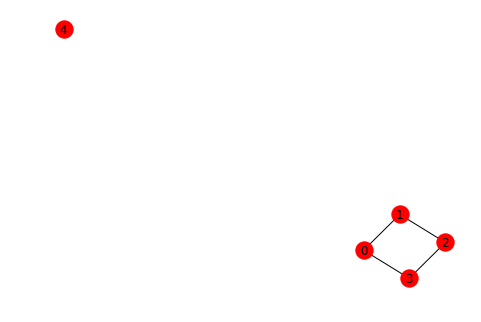

In [31]:
N = 5
# flying qubit index
f = 4

# desired graph edges (square)
E = [(0, 1), (1, 2), (2, 3), (3, 0)]
show_graph(range(N), E)

# initial state
Psi = qt.tensor(N*[ket_plus])


e = qt.tensor([X if i == f else Id for i in range(N)])

# cluster-state generation procedure
procedure_2D_error = swap(targets=[f, 3], N=N) * cz(i=f, j=0, N=N) * cz(i=f, j=2, N=N) * \
    swap(targets=[f, 1], N=N) * \
    e * \
    cz(i=f, j=0, N=N) * cz(i=f, j=2, N=N)

X3 = qt.tensor([X if i == 3 else Id for i in range(N)])

print(X3 * procedure_2D_error * Psi == graph_state_unitary(N, E) * Psi)
print(X3 * procedure_2D_error == procedure_2D)
print(X3 * procedure_2D_error == graph_state_unitary(N, E))

- Error $\sigma_x$ on $f$ just before its first SWAP(f, 3) just amounts to a X on 3.
- This is unsurprising -- more interesting case is when 3 then continues the pattern

### Knitting a larger 2D cluster state with X error:

True
False
True


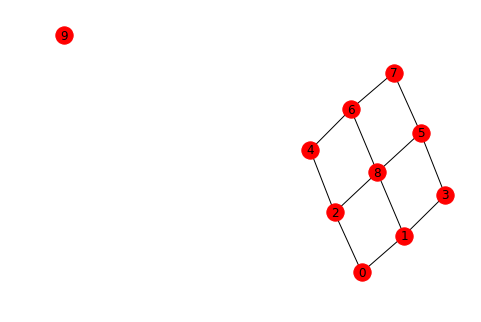

In [187]:
N = 10
# flying qubit index
f = 9

E = [(0, 1), (0, 2), (1, 3), (4, 2),
     (3, 5), (5, 7), (7, 6),
     (6, 4),
     (2, 8), (8, 1), (8, 5), (8, 6)]

show_graph(range(N), E)

# initial state
Psi = qt.tensor(N*[ket_plus])


e = qt.tensor([X if i == f else Id for i in range(N)])

knit = lambda i, j, k: swap(targets=[f, j], N=N) * cz(i=f, j=i, N=N) * cz(i=f, j=k, N=N)
procedure = knit(6, 7, 5) * knit(4, 6, 8) * knit(3, 5, 8) * knit(2, 8, 1) *\
    knit(2, 0, 1) *\
    swap(targets=[3, f], N=N) * cz(f, 1, N) *\
    swap(targets=[4, f], N=N) * cz(f, 2, N)

print(procedure * Psi == graph_state_unitary(N, E) * Psi)

X8 = qt.tensor([X if i == 8 else Id for i in range(N)])
procedure_with_error = knit(6, 7, 5) * knit(4, 6, 8) * knit(3, 5, 8) *\
    X8 *\
    knit(2, 8, 1) *\
    knit(2, 0, 1) *\
    swap(targets=[3, f], N=N) * cz(f, 1, N) *\
    swap(targets=[4, f], N=N) * cz(f, 2, N)

print(procedure_with_error * Psi == graph_state_unitary(N, E) * Psi)
X0 = qt.tensor([X if i == 0 else Id for i in range(N)])
print(X0 * procedure_with_error * Psi == graph_state_unitary(N, E) * Psi)

#### The $\sigma_x^{(8)}$ error is propagated to a local $\sigma_x^{(0)}$ error at the end of the circuit!
- Let's try all possible errors

In [194]:
from collections import defaultdict

def canonical_globalphase(psi):
    # rotate state back by phase of
    # first nonzero state coefficient
    for i in range(psi.dims[0][0]):
        coeff = psi.extract_states(i).full()[0][0]
        if coeff != 0:
            theta = np.angle(coeff)
            return qt.qip.globalphase(-theta, N=N) * psi
    raise ValueError('state is 0')

knit_ops = lambda i, j, k: [swap(targets=[f, j], N=N), cz(i=f, j=i, N=N), cz(i=f, j=k, N=N)]
procedure_ops = knit_ops(6, 7, 5) + knit_ops(4, 6, 8) + knit_ops(3, 5, 8) + knit_ops(2, 8, 1) +\
    knit_ops(2, 0, 1) + [
        swap(targets=[3, f], N=N), cz(f, 1, N), 
        swap(targets=[4, f], N=N), cz(f, 2, N)
    ]

knit_op_names = lambda i, j, k: ['SWAP_%s%s' % (f, j), 'CZ_%s%s' % (f, i), 'CZ_%s%s' % (f, k)]
procedure_op_names = knit_op_names(6, 7, 5) + knit_op_names(4, 6, 8) + knit_op_names(3, 5, 8) + knit_op_names(2, 8, 1) +\
    knit_op_names(2, 0, 1) + [
        'SWAP_%s%s' % (3, f),
        'CZ_%s%s' % (f, 1),
        'SWAP_%s%s' % (4, f),
        'CZ_%s%s' % (f, 2)
    ]

assert len(procedure_ops) == len(procedure_op_names)

print(len(procedure_ops), 'sequential SWAP and CZ gates in procedure')
assert reduce(lambda a, b: a*b,  procedure_ops) == procedure

target_state = procedure * Psi
target_state_modulo_local_pauli = set()
# correct output state
target_state_modulo_local_pauli.add(
    (procedure * Psi).full().tostring()
)
# all possible local errors
for sig in [X, Y, Z]:
    for i in range(N):
        err = qt.tensor([
            sig if j==i else Id
            for j in range(N)
        ])
        state = err * target_state
        state = canonical_globalphase(state)
        target_state_modulo_local_pauli.add(
            state.full().tostring()
        )

print(len(target_state_modulo_local_pauli), 'distict local pauli error target states')

single_procedure_error_out_states = defaultdict(list)
for sig, name in [(X, 'X'), (Y, 'Y'), (Z, 'Z')]:
    for i in range(N):
        for t in range(len(procedure_ops) + 1):
            err = qt.tensor([
                sig if j==i else Id
                for j in range(N)
            ])
#             assert list(reversed(
#                 list(reversed(procedure_ops))[:t] +
#                 [err] +
#                 list(reversed(procedure_ops))[t:]
#             )) == procedure_ops[:-t+1] + [err] + procedure_ops[-t+1:], 'array indexing bug'
            state = reduce(
                lambda a, b: a*b,
                list(reversed(
                    list(reversed(procedure_ops))[:t] +
                    [err] +
                    list(reversed(procedure_ops))[t:]
                ))
            ) * Psi
            state = canonical_globalphase(state)
            syndrome = (name, i, t)
            single_procedure_error_out_states[
                state.full().tostring()
            ].append(syndrome)
print(
    len(set(single_procedure_error_out_states.keys())),
    'distinct local pauli error during procedure final output states'
)
print(
    'local pauli error during procedure ⊆ local pauli error after procedure is',
    set(single_procedure_error_out_states.keys()).issubset(target_state_modulo_local_pauli)
)
print(
    'there are',
    len(set(single_procedure_error_out_states.keys()).difference(
        target_state_modulo_local_pauli)),
    'distinct procedure output syndromes that ARE NOT local pauli,\n',
    len(set(single_procedure_error_out_states.keys()).intersection(
        target_state_modulo_local_pauli)),
    'distinct procedure output syndromes that ARE local pauli',
)
# bad and good are poor names
# I mean the bad states are the ones where
# the local error hypothesis does not hold.
bad_states = [
    (qt.Qobj(np.frombuffer(state)), state)
    for state in set(single_procedure_error_out_states.keys()).difference(
        target_state_modulo_local_pauli
    )
]
good_states = [
    (qt.Qobj(np.frombuffer(state)), state)
    for state in set(single_procedure_error_out_states.keys()).intersection(
        target_state_modulo_local_pauli
    )
]

19 sequential SWAP and CZ gates in procedure
29 distict local pauli error target states
47 distinct local pauli error during procedure final output states
local pauli error during procedure ⊆ local pauli error after procedure is False
there are 18 distinct procedure output syndromes that ARE NOT local pauli,
 29 distinct procedure output syndromes that ARE local pauli


In [195]:
breaking_errors = []
for state in bad_states:
    breaking_errors += single_procedure_error_out_states[state[1]]

ok_errors = []
for state in good_states:
    ok_errors += single_procedure_error_out_states[state[1]]

print('Info: qubit %s is the flying qubit' % f)
print('This op sequence knits the 2D cluster state:')
for t, name in enumerate(reversed(procedure_op_names)):
    print('%s, t=%s' % (name ,t))

print('These %s errors during procedure do not map'
      ' to the target state mod a local pauli, up to a global phase:' % len(breaking_errors))
for name, i, t in sorted(breaking_errors, key=lambda s:s[-1]):
    print('%s_%s, t=%s' % (name, i, t))

print('These %s errors during procedure DO map to \n'
     'the target state mod a local pauli, \n'
      'up to a global phase:' % len(ok_errors))
print([
    '%s_%s, t=%s' % (name, i, t)
    for name, i, t in sorted(ok_errors, key=lambda s:s[-1])
])
print(
    '%s of the %s total error possibilities are "breaking"' % (
        len(breaking_errors) / float(len(breaking_errors) + len(ok_errors)),
        len(breaking_errors) + len(ok_errors)
    )
)

Info: qubit 9 is the flying qubit
This op sequence knits the 2D cluster state:
CZ_92, t=0
SWAP_49, t=1
CZ_91, t=2
SWAP_39, t=3
CZ_91, t=4
CZ_92, t=5
SWAP_90, t=6
CZ_91, t=7
CZ_92, t=8
SWAP_98, t=9
CZ_98, t=10
CZ_93, t=11
SWAP_95, t=12
CZ_98, t=13
CZ_94, t=14
SWAP_96, t=15
CZ_95, t=16
CZ_96, t=17
SWAP_97, t=18
These 71 errors during procedure do not map to the target state mod a local pauli, up to a global phase:
Y_2, t=1
Y_9, t=1
Y_2, t=2
Y_4, t=2
Y_1, t=3
Y_9, t=3
Y_2, t=3
Y_4, t=3
Y_1, t=4
Y_3, t=4
Y_2, t=4
Y_4, t=4
Y_3, t=5
Y_2, t=5
Y_4, t=5
Y_9, t=5
X_1, t=5
Y_1, t=5
Y_3, t=6
Y_2, t=6
Y_4, t=6
X_2, t=6
X_1, t=6
Y_1, t=6
Y_3, t=7
Y_2, t=7
Y_4, t=7
X_2, t=7
X_1, t=7
Y_1, t=7
Y_9, t=8
Y_3, t=8
Y_2, t=8
Y_4, t=8
X_2, t=8
Y_3, t=9
Y_9, t=9
Y_4, t=9
Y_3, t=10
Y_8, t=10
Y_4, t=10
Y_3, t=11
X_8, t=11
Y_8, t=11
Y_4, t=11
Y_9, t=11
X_8, t=12
Y_8, t=12
Y_4, t=12
Y_9, t=12
X_9, t=12
X_8, t=13
Y_8, t=13
Y_4, t=13
Y_5, t=13
X_5, t=13
Y_9, t=14
Y_4, t=14
Y_5, t=14
X_5, t=14
X_9, t=15
Y_5, t=15
X_